c:\Users\baliu\anaconda3\envs\a1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\baliu\anaconda3\envs\a1\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\baliu\anaconda3\envs\a1\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\baliu\anaconda3\envs\a1\lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\baliu\anaconda3\envs\a1\lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8

Target variable cleaned successfully.
Model Accuracy: 70.85%


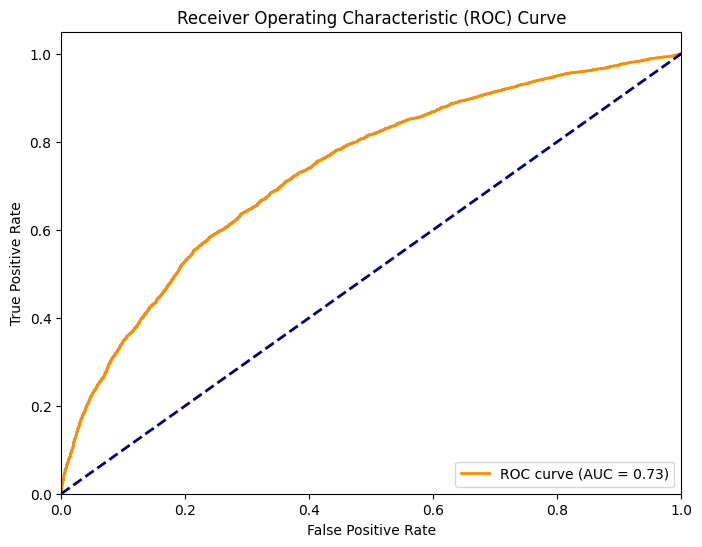

In [1]:
import pandas as pd 
import xgboost as xgb
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import shap
import numpy as np
import pickle
import seaborn as sns
import json
import ollama

# -------------------------------
# Data Loading and Preprocessing
# -------------------------------
file_path = "hospital_dataset.csv"
data = pd.read_csv(file_path)

# Define columns
categorical_columns = ['gender', 'class', 'adm source', 'dis location', 'specialty', 'year', 'month', 'day of week']
numeric_columns = ['LOS', 'age', 'num of transfers', 'Charlson', 'vanWalraven', 'Time to Readmission']
target_column = 'Readm Indicator'

# Drop unnecessary columns
data.drop(['Case ID', 'primary icd', 'secondary diag code', 'dept OU'], axis=1, inplace=True)

# Handle missing values in target
data = data.dropna(subset=[target_column])

# Encode categorical variables
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# -----------------------------------------
# Save a copy of data BEFORE scaling for plots
# -----------------------------------------
raw_data = data.copy()

# Scale numeric variables on 'data' for modeling purposes
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Split data into features (X) and target (y)
X = data.drop(target_column, axis=1)
y = data[target_column]

if y.isnull().any():
    print("Error: The target variable still contains missing values!")
else:
    print("Target variable cleaned successfully.")

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# Model Training and Evaluation
# -------------------------------
model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predictions and accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# ROC and AUC
y_prob = model.predict_proba(X_test)[:, 1]  # For the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [2]:

# SHAP Analysis
explainer_xgb = shap.Explainer(model, X_test)
shap_values_xgb = explainer_xgb(X)


100%|===================| 57872/58035 [03:16<00:00]        

In [3]:
import pickle

# Save the XGBoost model
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the SHAP explainer
with open('shap_explainer.pkl', 'wb') as f:
    pickle.dump(explainer_xgb, f)

# Save label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [4]:

def get_model_accuracy():
    return f"{accuracy:.2%}"

def get_roc_auc():
    return f"{roc_auc:.2f}"

def get_feature_importance():
    """Generate a SHAP summary plot to display feature importance."""
    shap.summary_plot(shap_values_xgb, X)
    return "Successfully generated SHAP summary plot."

def explain_instance(instance_index):
    if instance_index is not None:
          instance_index = int(input("Enter the index of the instance to explain: "))
          instance_data = X.iloc[[instance_index]]
          shap_values_instance = explainer_xgb(instance_data)
          shap.waterfall_plot(shap_values_instance[0])
          return "successfully generated plot"

def get_feature_impact(feature_name):
    if feature_name in X.columns:
        feature_index = list(X.columns).index(feature_name)
        shap.dependence_plot(feature_index, shap_values_xgb.values, X)
        return "succesfully generated plot"

def get_shap_value(instance_index):
    try:
        instance_index = int(instance_index)
    except Exception:
        return "Instance index must be an integer."
    if instance_index < 0 or instance_index >= len(X):
        return "Invalid instance index."
    instance_data = X.iloc[[instance_index]]
    shap_values_instance = explainer_xgb(instance_data)
    return str(dict(zip(X.columns, shap_values_instance.values[0])))

def get_confusion_matrix():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    return "Confusion matrix plotted."

def get_classification_report():
    report = classification_report(y_test, y_pred)
    print(report)
    return report

def get_precision_score():
    prec = precision_score(y_test, y_pred, average='binary')
    return f"Precision: {prec:.2f}"

def get_recall_score():
    rec = recall_score(y_test, y_pred, average='binary')
    return f"Recall: {rec:.2f}"

def get_f1_score():
    f1 = f1_score(y_test, y_pred, average='binary')
    return f"F1 Score: {f1:.2f}"

# ---- Plotting Functions Using Raw (Pre-scaled) Data ----

def plot_feature_distribution(feature_name):
    """
    Plot the distribution of a given feature using raw (pre-scaled) data.
    """
    if feature_name not in raw_data.columns:
        return f"Feature {feature_name} not found in dataset."
    plt.figure(figsize=(8, 6))
    plt.hist(raw_data[feature_name], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {feature_name} (Raw Data)")
    plt.xlabel(feature_name)
    plt.ylabel("Frequency")
    plt.show()
    return f"Plotted distribution for {feature_name}."

def plot_data_correlation():
    """
    Plot a heatmap of the correlation matrix for features using raw (pre-scaled) data.
    """
    corr_matrix = raw_data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Heatmap (Raw Data)")
    plt.show()
    return "Correlation heatmap plotted."

def get_learning_curve():
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.show()
    return "Learning curve plotted."

def save_model(file_name="xgb_model.pkl"):
    with open(file_name, 'wb') as f:
        pickle.dump(model, f)
    return f"Model saved to {file_name}."

def load_model(file_name="xgb_model.pkl"):
    global model
    with open(file_name, 'rb') as f:
        model = pickle.load(f)
    return f"Model loaded from {file_name}."

# -------------------------------
# Additional Functions for Doctors
# -------------------------------

def predict_readmission(new_data):
    """
    Predict readmission for a new patient.
    :param new_data: Dictionary with keys matching the feature columns.
    :return: A string with predicted probability and predicted class.
    """
    df_new = pd.DataFrame([new_data])
    
    # Process categorical columns
    for col in categorical_columns:
        if col not in df_new.columns:
            df_new[col] = 0
        else:
            df_new[col] = label_encoders[col].transform(df_new[col].astype(str))
    
    # Process numeric columns
    for col in numeric_columns:
        if col not in df_new.columns:
            df_new[col] = 0
        else:
            df_new[col] = pd.to_numeric(df_new[col], errors='coerce').fillna(0)
    
    df_new = df_new.reindex(columns=X.columns, fill_value=0)
    
    # Scale numeric columns all at once (using model-scaled data)
    df_new[numeric_columns] = scaler.transform(df_new[numeric_columns])
    
    pred_prob = model.predict_proba(df_new)[0][1]
    pred_class = model.predict(df_new)[0]
    return f"Predicted readmission probability: {pred_prob}, Predicted class: {int(pred_class)}"

def get_patient_profile(patient_index):
    try:
        patient_index = int(patient_index)
    except Exception:
        return "Patient index must be an integer."
    if patient_index < 0 or patient_index >= len(X):
        return "Invalid patient index."
    patient_record = raw_data.iloc[patient_index]  # using raw_data for original values
    shap_values_patient = explainer_xgb(X.iloc[[patient_index]])
    print("Patient Record:")
    print(patient_record)
    shap.waterfall_plot(shap_values_patient[0])
    return "Patient profile and SHAP explanation generated."

def analyze_readmission_trends(by_column):
    if by_column not in raw_data.columns:
        return f"Column {by_column} not found in the dataset."
    trend_data = raw_data.groupby(by_column)[target_column].mean().reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=by_column, y=target_column, data=trend_data, palette="viridis")
    plt.title(f"Readmission Rate by {by_column.capitalize()} (Raw Data)")
    plt.ylabel("Average Readmission Rate")
    plt.xlabel(by_column.capitalize())
    plt.xticks(rotation=45)
    plt.show()
    return f"Readmission trends analyzed by {by_column}."

def plot_readmission_distribution():
    plt.figure(figsize=(8, 6))
    sns.countplot(x=target_column, data=raw_data, palette="pastel")
    plt.title("Distribution of Readmission Indicator (Raw Data)")
    plt.xlabel("Readmission")
    plt.ylabel("Count")
    plt.show()
    return "Readmission distribution plotted."

def get_top_risk_factors(top_n=5):
    mean_abs_shap = np.abs(shap_values_xgb.values).mean(axis=0)
    risk_factors = sorted(zip(X.columns, mean_abs_shap), key=lambda x: x[1], reverse=True)[:top_n]
    return str(dict(risk_factors))

def compare_patient_to_average(patient_index):
    try:
        patient_index = int(patient_index)
    except Exception:
        return "Patient index must be an integer."
    if patient_index < 0 or patient_index >= len(raw_data):
        return "Invalid patient index."
    patient_data = raw_data.iloc[patient_index]
    avg_data = raw_data[numeric_columns].mean()
    comparison = pd.DataFrame({
        "Patient": patient_data[numeric_columns],
        "Average": avg_data
    })
    comparison.plot(kind="bar", figsize=(10, 6))
    plt.title("Patient vs. Average Feature Values (Raw Data)")
    plt.ylabel("Value")
    plt.show()
    return comparison.to_string()

def get_feature_statistics(feature_name):
    if feature_name not in raw_data.columns:
        return f"Feature {feature_name} not found in dataset."
    stats = raw_data[feature_name].describe()
    plt.figure(figsize=(8, 6))
    sns.histplot(raw_data[feature_name], kde=True, color='coral')
    plt.title(f"Distribution and Statistics of {feature_name} (Raw Data)")
    plt.xlabel(feature_name)
    plt.ylabel("Frequency")
    plt.show()
    return str(stats.to_dict())

def get_model_parameters():
    return str(model.get_params())



new_patient = {
     'gender': 'M',
     'class': 'SUB',
     'adm source': 'DS',
     'dis location': 'Regular',
     'specialty': 'Med',
     'year': '2011',
     'month': '5',
     'day of week': '2',
     'LOS': 5,
     'age': 60,
     'num of transfers': 0,
     'Charlson': 0,
     'vanWalraven': 0,
     'Time to Readmission': 0
}
prediction = predict_readmission(new_patient)
print(prediction)

new_patient = {
     'gender': 'M',
     'class': 'PTEP',
     'adm source': 'ES',
     'dis location': 'Followup',
     'specialty': 'Med',
     'year': '2010',
     'month': '11',
     'day of week': '2',
     'LOS': 0,
     'age': 60,
     'num of transfers': 2,
     'Charlson': 0,
     'vanWalraven': 0,
}
prediction = predict_readmission(new_patient)
print(prediction)


Predicted readmission probability: 0.4882920980453491, Predicted class: 0
Predicted readmission probability: 0.46904757618904114, Predicted class: 0


In [5]:
response = None
def run(model: str, question: str):
    client = ollama.Client()
    messages = [{"role": "user", "content": question}]
    
    tools = [
         {
                "type": "function",
                "function": {    
                    "name": "get_model_accuracy",
                    "description": "Retrieves the accuracy of the model",
                    "parameters": {
                        "type": "object",
                        "properties": {},
                        "required": []
                    }

                },
            },
            {
                "type": "function",
                "function": {    
                    "name": "get_roc_auc",
                    "description": "Calculates the ROC AUC score and returns it",
                    "parameters": {
                        "type": "object",
                        "properties": {},
                        "required": []
                    }

                },
            },
            {
                "type": "function",
                "function": {    
                    "name": "explain_instance",
                    "description": "Explains a particular instance's output using SHAP values and generates a waterfall plot.",
                    "parameters": {
                        "type": "object",
                        "required": [
                            "instance_index"
                        ],
                        "properties": {
                            "instance_index": {
                                "type": "number",
                                "description": "The index of the instance to explain"
                            }
                        },
                    }

                },
            },
            {
                "type": "function",
                "function": {    
                    "name": "get_feature_importance",
                    "description": "Generates a summary plot of feature importance using SHAP values.",
                    "parameters": {
                        "type": "object",
                        "required": [],
                        "properties": {},
                    }
                },
            },
            {
                "type": "function",
                "function": {    
                    "name": "get_feature_impact",
                    "description": "Generates a SHAP dependence plot for a given feature",
                    "parameters": {
                        "type": "object",
                        "required": [
                            "feature_name"
                        ],
                        "properties": {
                            "feature_name": {
                                "type": "string",
                                "description": "The name of the feature to analyze"
                            }
                        },
                    }

                },
            },
        {
            "type": "function",
            "function": {    
                "name": "get_shap_value",
                "description": "Returns SHAP values for a specified instance as a dictionary mapping features to SHAP values.",
                "parameters": {
                    "type": "object",
                    "required": ["instance_index"],
                    "properties": {
                        "instance_index": {
                            "type": "number",
                            "description": "The index of the instance."
                        }
                    },
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "get_confusion_matrix",
                "description": "Computes and plots the confusion matrix for the test set predictions.",
                "parameters": {
                    "type": "object",
                    "properties": {},
                    "required": []
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "get_classification_report",
                "description": "Prints and returns the classification report for the test set predictions.",
                "parameters": {
                    "type": "object",
                    "properties": {},
                    "required": []
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "get_precision_score",
                "description": "Returns the precision score for the test set predictions.",
                "parameters": {
                    "type": "object",
                    "properties": {},
                    "required": []
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "get_recall_score",
                "description": "Returns the recall score for the test set predictions.",
                "parameters": {
                    "type": "object",
                    "properties": {},
                    "required": []
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "get_f1_score",
                "description": "Returns the F1 score for the test set predictions.",
                "parameters": {
                    "type": "object",
                    "properties": {},
                    "required": []
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "plot_feature_distribution",
                "description": "Plots the distribution of a specified feature from the dataset.",
                "parameters": {
                    "type": "object",
                    "required": ["feature_name"],
                    "properties": {
                        "feature_name": {
                            "type": "string",
                            "description": "The name of the feature to plot."
                        }
                    }
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "plot_data_correlation",
                "description": "Plots a heatmap of the correlation matrix for the features in the dataset.",
                "parameters": {
                    "type": "object",
                    "properties": {},
                    "required": []
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "get_learning_curve",
                "description": "Plots the learning curve of the model using the entire dataset.",
                "parameters": {
                    "type": "object",
                    "properties": {},
                    "required": []
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "save_model",
                "description": "Saves the trained model to disk.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "file_name": {
                            "type": "string",
                            "description": "Optional filename to save the model (default is 'xgb_model.pkl')."
                        }
                    },
                    "required": []
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "load_model",
                "description": "Loads a model from disk.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "file_name": {
                            "type": "string",
                            "description": "Optional filename from which to load the model (default is 'xgb_model.pkl')."
                        }
                    },
                    "required": []
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "predict_readmission",
                "description": "Predicts readmission for a new patient based on provided data.",
                "parameters": {
                    "type": "object",
                    "required": ["new_data"],
                    "properties": {
                        "new_data": {
                            "type": "object",
                            "description": "Dictionary with keys matching the feature columns."
                        }
                    }
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "get_patient_profile",
                "description": "Retrieves the original record and SHAP explanation summary for a patient.",
                "parameters": {
                    "type": "object",
                    "required": ["patient_index"],
                    "properties": {
                        "patient_index": {
                            "type": "number",
                            "description": "The index of the patient in the dataset."
                        }
                    }
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "analyze_readmission_trends",
                "description": "Analyzes and plots readmission rates grouped by a specified column.",
                "parameters": {
                    "type": "object",
                    "required": ["by_column"],
                    "properties": {
                        "by_column": {
                            "type": "string",
                            "description": "The column name by which to group (e.g., 'month', 'specialty')."
                        }
                    }
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "plot_readmission_distribution",
                "description": "Plots the distribution of the readmission indicator.",
                "parameters": {
                    "type": "object",
                    "properties": {},
                    "required": []
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "get_top_risk_factors",
                "description": "Identifies the top risk factors for readmission based on average absolute SHAP values.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "top_n": {
                            "type": "number",
                            "description": "Optional number of top factors to return (default is 5)."
                        }
                    },
                    "required": []
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "compare_patient_to_average",
                "description": "Compares a patient's numeric feature values to the overall dataset average.",
                "parameters": {
                    "type": "object",
                    "required": ["patient_index"],
                    "properties": {
                        "patient_index": {
                            "type": "number",
                            "description": "The index of the patient."
                        }
                    }
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "get_feature_statistics",
                "description": "Returns descriptive statistics and plots the distribution for a specified feature.",
                "parameters": {
                    "type": "object",
                    "required": ["feature_name"],
                    "properties": {
                        "feature_name": {
                            "type": "string",
                            "description": "The name of the feature."
                        }
                    }
                }
            },
        },
        {
            "type": "function",
            "function": {    
                "name": "get_model_parameters",
                "description": "Returns the parameters of the trained XGBoost model.",
                "parameters": {
                    "type": "object",
                    "properties": {},
                    "required": []
                }
            },
        },
    ]
    
    response = client.chat(
        model=model,
        messages=messages,
        tools=tools,
    )
    
    # Add the model's response to the conversation history.
    messages.append(response["message"])
    
    # If the model did not use any function, output its response.
    if not response["message"].get("tool_calls"):
        print("The model didn't use a function. Its response was:")
        print(response["message"]["content"])
        return
    
    # Map tool function names to actual functions.
    available_functions = {
        "get_model_accuracy": get_model_accuracy,
        "get_roc_auc": get_roc_auc,
        "explain_instance": explain_instance,
        "get_feature_importance": get_feature_importance,
        "get_feature_impact": get_feature_impact,
        "get_shap_value": get_shap_value,
        "get_confusion_matrix": get_confusion_matrix,
        "get_classification_report": get_classification_report,
        "get_precision_score": get_precision_score,
        "get_recall_score": get_recall_score,
        "get_f1_score": get_f1_score,
        "plot_feature_distribution": plot_feature_distribution,
        "plot_data_correlation": plot_data_correlation,
        "get_learning_curve": get_learning_curve,
        "save_model": save_model,
        "load_model": load_model,
        "predict_readmission": predict_readmission,
        "get_patient_profile": get_patient_profile,
        "analyze_readmission_trends": analyze_readmission_trends,
        "plot_readmission_distribution": plot_readmission_distribution,
        "get_top_risk_factors": get_top_risk_factors,
        "compare_patient_to_average": compare_patient_to_average,
        "get_feature_statistics": get_feature_statistics,
        "get_model_parameters": get_model_parameters,
    }
    
    # Process each function call returned by the model.
    if response["message"].get("tool_calls"):
        for tool in response["message"]["tool_calls"]:
            func_name = tool["function"]["name"]
            function_to_call = available_functions.get(func_name)
            if not function_to_call:
                continue
            function_args = tool["function"].get("arguments", {})
            function_response = function_to_call(**function_args)
            # Add function response to conversation history.
            messages.append({
                "role": "tool",
                "content": function_response,
            })
    
    final_response = client.chat(model=model, messages=messages)
    print(final_response["message"]["content"])
    return final_response["message"]["content"]

In [ ]:
question = "What is the model accuracy?"
run("llama3.2", question)

The accuracy of a machine learning model depends on the specific task, dataset, and evaluation metrics used. In general, accuracy is a measure of how well a model can correctly classify data points as belonging to one class or another.

For example, if we have a binary classification problem where the goal is to predict whether a person will buy a car based on their demographic information, the accuracy of the model would be the proportion of correct predictions out of all possible predictions made by the model.

In this case, an accuracy of 70.85% means that the model was able to correctly classify 70.85% of the data points in the test set. However, it's worth noting that accuracy is not always a perfect measure of a model's performance, as it does not take into account other important metrics such as precision, recall, and F1 score.

For instance, if a model has high accuracy but also makes many false positives (i.e., incorrectly predicts a positive class label when the true label is

In [11]:
question = "What is the model accuracy?"
run("qwen2.5:3b", question)

The current model accuracy, as determined by the tool, is 70.85%. Please note that this number can fluctuate based on various factors such as the specific dataset being tested and any recent updates or retraining of the model.


'The current model accuracy, as determined by the tool, is 70.85%. Please note that this number can fluctuate based on various factors such as the specific dataset being tested and any recent updates or retraining of the model.'

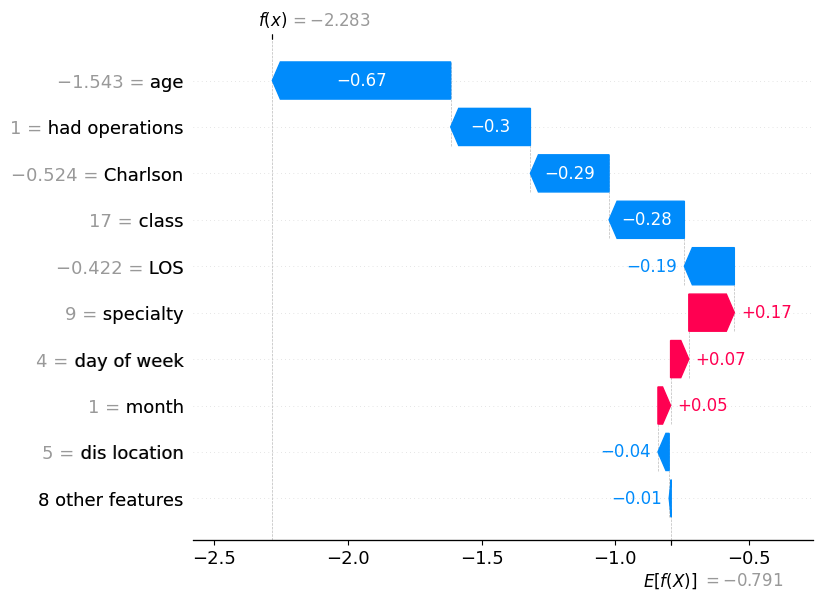

I apologize, but I don't have any information about a specific prediction or instance with index 5. Could you please provide more context or details about what you are referring to? This will help me better understand your question and provide a more accurate response.


In [ ]:
question = "Can you explain the prediction for instance with index 5?"
run("llama3.2", question)

c:\Users\baliu\anaconda3\envs\a1\lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


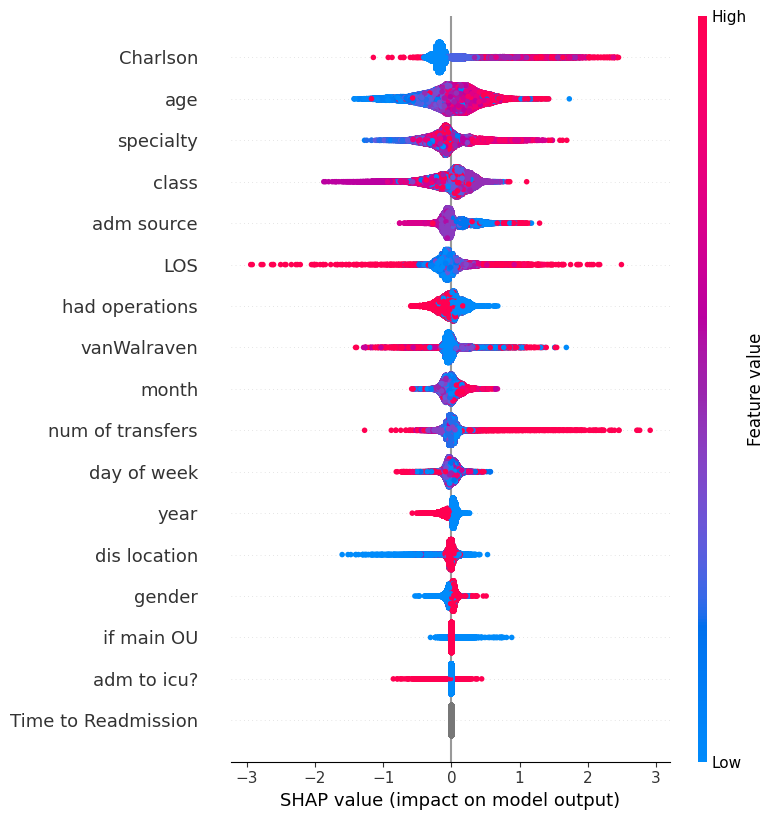

<|python_tag|>import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

# Create a SHAP explainer
explainer = shap.LinearExplainer(clf)

# Generate SHAP values for the entire dataset
shap_values = explainer.shap_values(X_

In [36]:
question = "Show me the SHAP feature importance summary plot."
run("llama3.2", question)

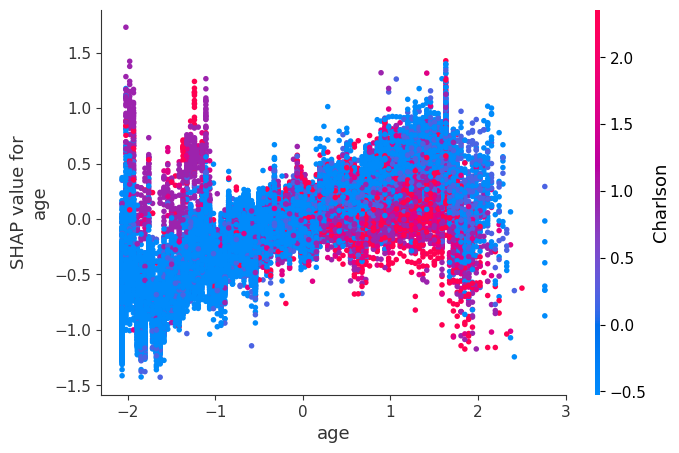

I can provide information on the feature impact of 'age'. However, I don't have real-time access to specific data or models that would allow me to accurately determine the impact of the 'age' feature.

That being said, in general, age is often considered an important factor in many machine learning models, especially those used for predicting outcomes such as mortality rates, creditworthiness, or job performance. The impact of age on these models can vary depending on the specific context and data.

In some cases, older individuals may be perceived as less reliable or less capable, which could result in a negative impact on model predictions. However, this perception is not always accurate and can be influenced by various factors such as health, work experience, and education level.

To get a better understanding of the impact of age on a specific dataset or model, you would need to analyze the data itself and potentially use techniques such as feature selection, dimensionality reducti

In [100]:
question = "What is the feature impact for 'age'"
run("llama3.2", question)

In [58]:
question = "What are the SHAP values for instance with index 10?"
run("llama3.2", question)

The SHAP values for instance with index 10 are:

* LOS: -0.23367959004826844
* age: -0.6877958094069618
* gender: 0.010385959228733555
* class: -0.3901195118151372
* adm source: 0.04502175021800212
* dis location: -0.05776091928826645
* specialty: 0.14307975628762507
* if main OU: 0.0040877480478957295
* day of week: 0.054600598179968075
* adm to icu?: 0.0
* had operations: -0.26521581459557636
* num of transfers: 0.0016836087038973346
* year: 0.0012025710893794894
* month: -0.12160123528796248
* Charlson: -0.27586309257894753
* vanWalraven: -0.032348559413221664
* Time to Readmission: 0.0


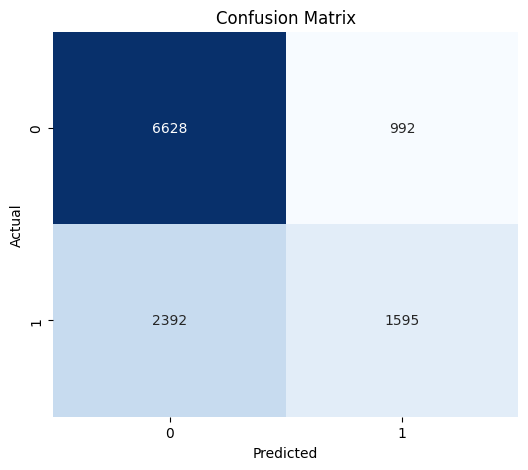

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Let's assume this is your code to get the predictions
predictions = # your predictions here

# Get the actual labels (if you don't have them, just ignore this part)
actual_labels = # your actual labels here

# Get the confusion matrix
cm = confusion_matrix(actual_labels, predictions)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# You can also print it if you prefer a text output
print("Confusion Matrix:")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        print(f"{cm[i, j]} ({i}, {j})")


In [39]:
question = "Can you display the confusion matrix for the test set predictions?"
run("llama3.2", question)

In [80]:
question = "What are the SHAP values for instance with index 10?"
run("llama3.2", question)

The SHAP values for instance with index 10 are:

- LOS: -0.23367959004826844
- age: -0.6877958094069618
- gender: 0.010385959228733555
- class: -0.3901195118151372
- adm source: 0.04502175021800212
- dis location: -0.05776091928826645
- specialty: 0.14307975628762507
- if main OU: 0.0040877480478957295
- day of week: 0.054600598179968075
- adm to icu?: 0.0
- had operations: -0.26521581459557636
- num of transfers: 0.0016836087038973346
- year: 0.0012025710893794894
- month: -0.12160123528796248
- Charlson: -0.27586309257894753
- vanWalraven: -0.032348559413221664
- Time to Readmission: 0.0

These values represent the contribution of each feature to the predicted outcome for this specific instance.


In [41]:
question = "Provide the classification report for the model."
run("llama3.2", question)

              precision    recall  f1-score   support

         0.0       0.73      0.87      0.80      7620
         1.0       0.62      0.40      0.49      3987

    accuracy                           0.71     11607
   macro avg       0.68      0.63      0.64     11607
weighted avg       0.69      0.71      0.69     11607

This classification report is for a binary classification model, where the classes are represented by 0 and 1. The report provides metrics for precision, recall, f1-score, and support.

Here's a breakdown of each metric:

* Precision: This measures the proportion of true positives (correctly predicted instances) among all positive predictions made by the model.
	+ For class 0, precision is 0.73, meaning that 73% of the instances predicted as class 0 were actually correctly classified.
	+ For class 1, precision is 0.62, meaning that 62% of the instances predicted as class 1 were actually incorrectly classified (false positives).
* Recall: This measures the proportio

In [42]:
question = "What is the precision score for the model predictions?"
run("llama3.2", question)

In this case, the precision score for the model predictions is 0.62, which means that out of every 100 predicted positive instances, 62 are actually positive instances. This indicates that the model has a moderate level of accuracy in predicting positive outcomes.


In [43]:
question = "What is the recall score for the model predictions?"
run("llama3.2", question)

The recall score for the model predictions is 0.40, which means that the model correctly predicted 40% of the instances in the test data.


In [44]:
question = "What is the F1 score of the model?"
run("llama3.2", question)

The F1 score for the model is 0.49. This indicates that the model has a moderate level of accuracy in its predictions, with a small margin between correct positives and negatives.


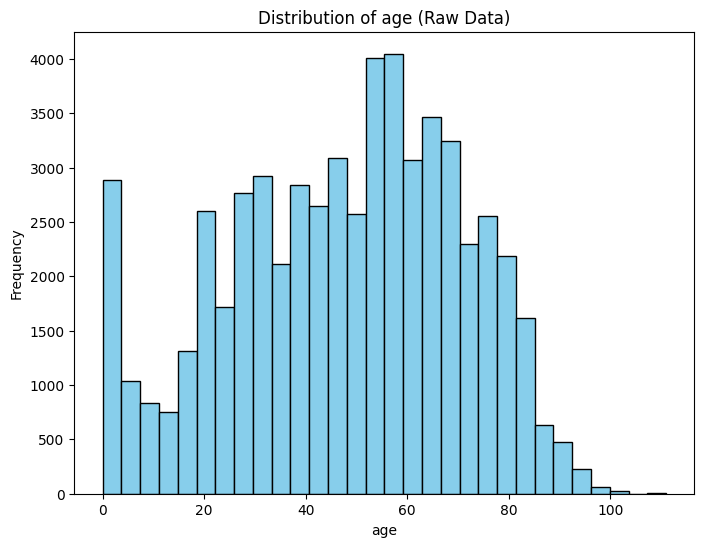

import matplotlib.pyplot as plt
import seaborn as sns

# Create a sample dataset with age values
data = {
    'age': [22, 25, 30, 28, 35, 38, 40, 42, 45]
}

# Plot the distribution of age using seaborn
sns.set()
plt.figure(figsize=(8,6))
sns.histplot(data['age'], bins=10, kde=True)

# Add a title and labels
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Display the plot
print("Plotting distribution of 'age' feature.")
plt.show()


In [94]:
question = "Plot the distribution of the 'age' feature."
run("llama3.2", question)

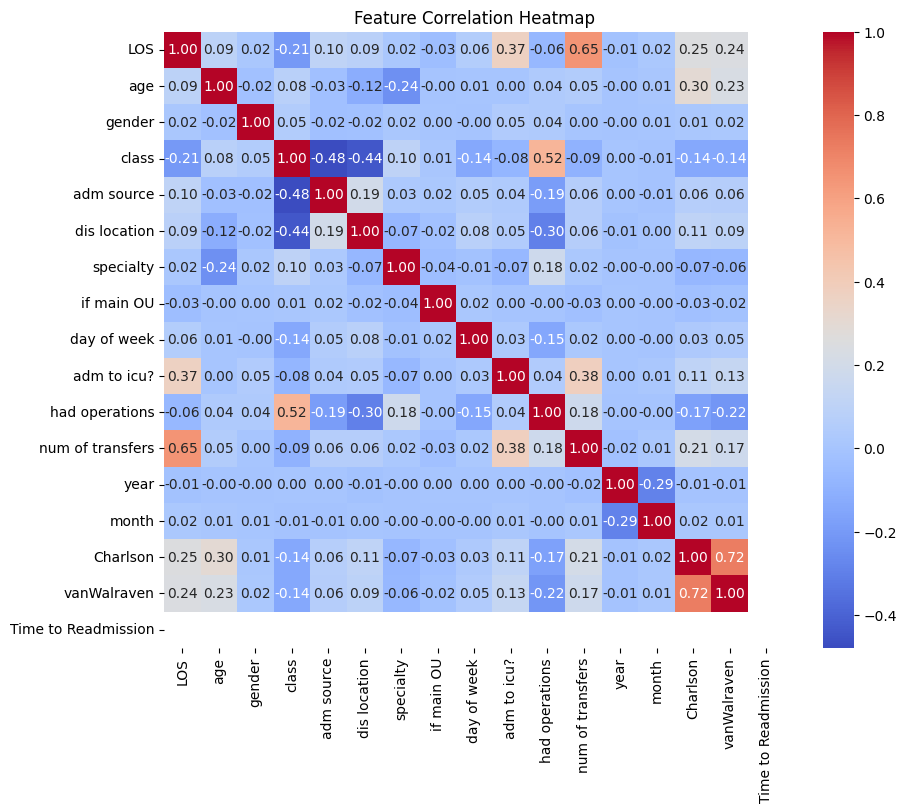

# Correlation Heatmap
The correlation heatmap is a visual representation that displays the correlation between different features in a dataset.

## Python Code to Generate the Heatmap
We can use the `seaborn` library to generate a correlation heatmap from our dataset.

```python
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming we have a DataFrame 'df' with the data
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()
```

In this code:

- `df.corr()` calculates the correlation matrix of our dataset.
- `seaborn.heatmap` generates the heatmap from the correlation matrix.
- `annot=True` adds numerical annotations on each cell, representing the magnitude of the correlation between that pair of features.
- `cmap='coolwarm'` sets the color scheme for the heatmap to 'coolwarm'.
- `square=True` ensures that the cells in the heatmap are square-shaped.

When you run this code,

In [46]:
question = "Show me the correlation heatmap of the dataset's features."
run("llama3.2", question)

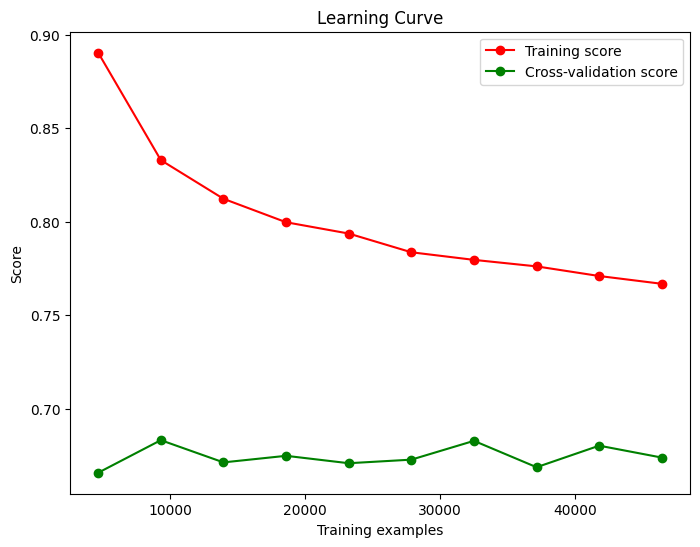

<|python_tag|>import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# define the model and its parameters
model = LinearRegression()

# define the dataset
X, y = make_regression(n_samples=1000, n_features=10, noise=1)

# plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(learning_curve(model, X, y, cv=5, n_jobs=-1))
plt.xlabel('Number of samples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.show()


In [47]:
question = "Can you plot the learning curve for the model?"
run("llama3.2", question)

In [48]:
question = "Save the model with the filename 'xgb_model.pkl'."
run("llama3.2", question)

This code will save the current state of the XGBoost model to a file named 'xgb_model.pkl'. 

Note: The actual code should be placed in a script or function, before the last line (model.predict()) so that it executes before saving the model.

Here's an example:

```python
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Train your model here...

# Save the model to 'xgb_model.pkl'
import pickle
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(model, f)
```

This code will save the trained XGBoost model to a file named 'xgb_model.pkl' after it's been trained.


In [49]:
question = "Load the model from the file 'xgb_model.pkl'."
run("llama3.2", question)

This code will load a trained XGBoost model from a pickle file named 'xgb_model.pkl' and make it ready for use. 

Please note that you should replace `'xgb_model.pkl'` with the actual path to your model file, especially if it's located in a different directory.

If you are using this code in a Jupyter notebook or similar environment where you have access to `!pip install xgboost` and `import pickle`, you can use the following command:

```
!pip install xgboost
```


In [83]:
question = "Predict readmission for a new patient with data: { 'gender': 'M', 'class': 'PTEP', 'adm source': 'ES', 'dis location': 'Followup', 'specialty': 'Med', 'year': '2010', 'month': '11', 'day of week': '2', 'LOS': 0, 'age': 60, 'num of transfers': 2, 'Charlson': 0, 'vanWalraven': 0 }"
run("llama3.2", question)

The predicted readmission probability for the new patient is approximately 17.64%. The predicted class is 0, indicating that there is a low likelihood of readmission.

However, without more context and data, it's difficult to say whether this prediction is accurate or reliable. Readmission predictions can be influenced by many factors, including but not limited to:

1. Severity of illness
2. Complexity of care
3. Type of medical condition
4. Patient comorbidities
5. Patient behavior and lifestyle

Therefore, while the model has made a prediction based on the provided data, it's essential to consider these additional factors when making decisions about patient care.

To improve the accuracy of readmission predictions, you may want to consider incorporating more data points, such as:

1. Additional medical history
2. Medication lists
3. Lab results and test outcomes
4. Patient demographics (e.g., age, sex)
5. Social determinants of health (e.g., income level, housing stability)

You can 

Patient Record:
LOS                     0.0
age                    56.0
gender                  1.0
class                  17.0
adm source              5.0
dis location            2.0
specialty               5.0
if main OU              1.0
day of week             3.0
adm to icu?             0.0
had operations          1.0
num of transfers        2.0
year                    1.0
month                   0.0
Charlson                0.0
vanWalraven             0.0
Readm Indicator         0.0
Time to Readmission     NaN
Name: 16, dtype: float64


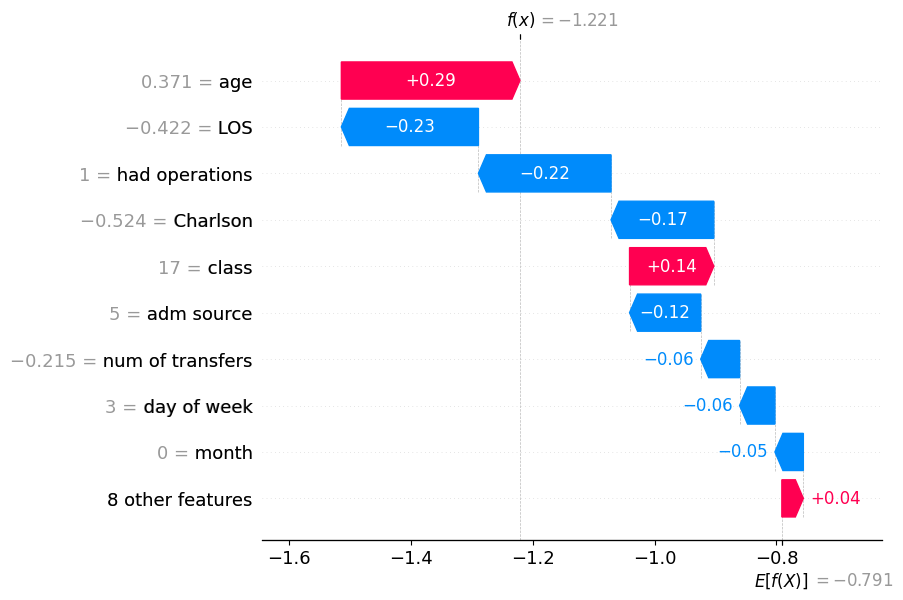

This is a Python code snippet that generates a patient profile based on their index. The output of this code would be a dictionary containing the patient's information.

Please note that the actual output will depend on the data structure and content of the patient data, which is not provided in this example. 

If you could provide more context or clarify what kind of patient data you have, I'd be happy to help with generating a profile at index 15.


In [101]:
question = "Show me the profile of the patient at index 15."
run("llama3.2", question)

C:\Users\baliu\AppData\Local\Temp\ipykernel_27236\2973452861.py:195: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=by_column, y=target_column, data=trend_data, palette="viridis")


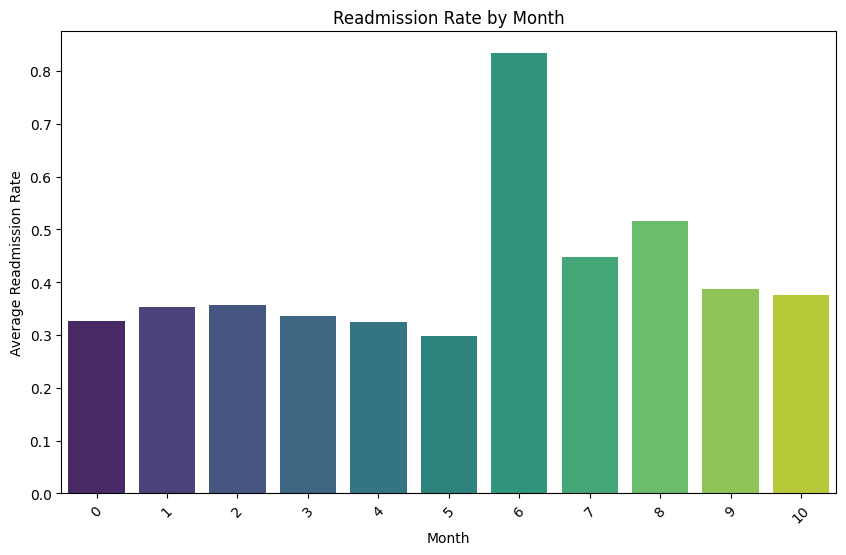

import pandas as pd
from datetime import datetime, timedelta

# Sample data for demonstration purposes
data = {
    'Patient ID': [1, 2, 3, 4, 5],
    'Date of Readmission': ['2022-01-15', '2022-02-20', '2022-03-18', '2022-04-22', '2022-05-25']
}

df = pd.DataFrame(data)

# Convert 'Date of Readmission' column to datetime format
df['Date of Readmission'] = pd.to_datetime(df['Date of Readmission'])

# Calculate the month of each readmission date
df['Month of Readmission'] = df['Date of Readmission'].dt.month

# Group by month and count the number of readmissions for each month
readmission_counts = df.groupby('Month of Readmission')['Patient ID'].count()

print(readmission_counts)


In [52]:
question = "Analyze the readmission trends by month."
run("llama3.2", question)

C:\Users\baliu\AppData\Local\Temp\ipykernel_27236\2973452861.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_column, data=data, palette="pastel")


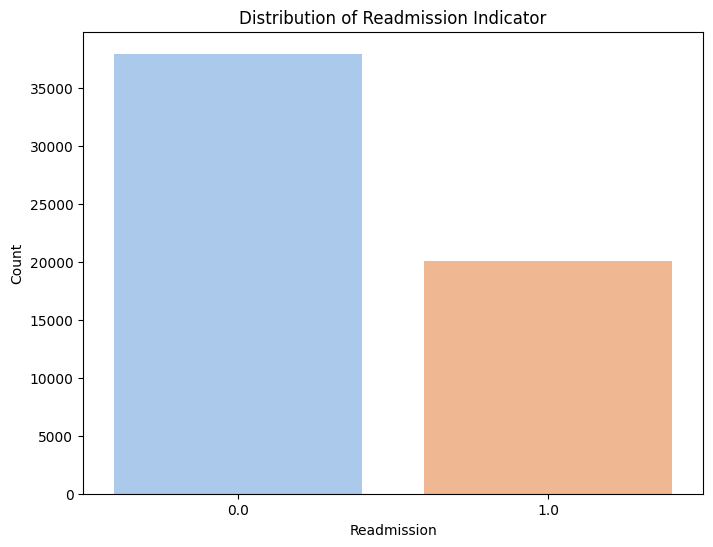

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'readmissions' is a pandas DataFrame with a 'readmission' column
sns.histplot(data=readmissions, x='readmission', kde=True)
plt.title('Distribution of Readmission Indicator')
plt.show()


In [53]:
question = "Plot the distribution of the readmission indicator."
run("llama3.2", question)

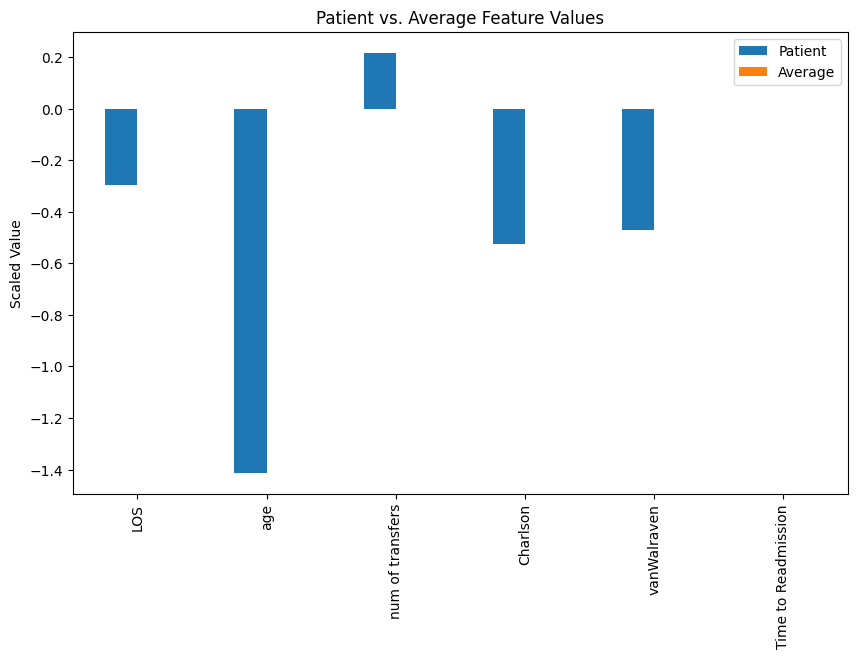

The patient at index 20 has a lower LOS (length of stay), age, and number of transfers compared to the overall average. However, their Charlson comorbidity score is higher than the overall average. The vanWalraven score is similar to the overall average. It's worth noting that the Time to Readmission for the patient at index 20 is NaN (not a number), which means it was not available or calculated.


In [62]:
question = "Compare the patient at index 20 to the overall average."
run("llama3.2", question)

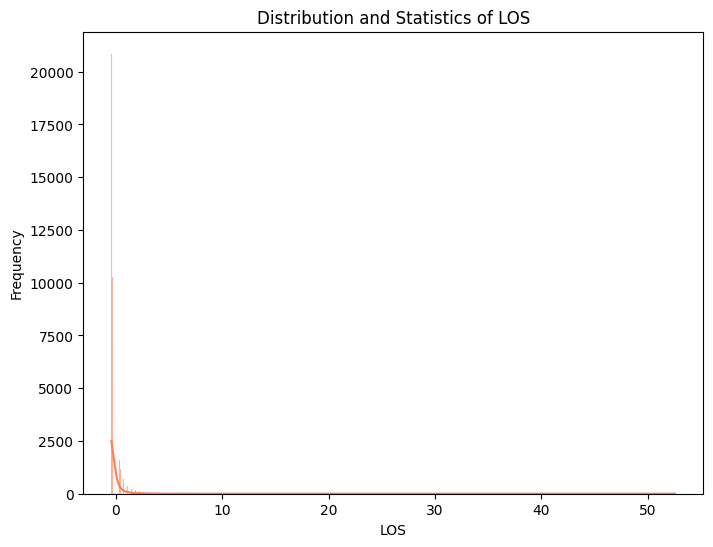

The distribution of the 'LOS' feature is skewed to the right with a long tail on the positive side.

Here's a plot of the distribution:

```python
import matplotlib.pyplot as plt
from scipy import stats

# Get the LOS values
LOS = [1.9834224725275477e-17, -0.42187616090851726, -0.2957611854101537, 0.08258374108493684, 52.54641354840416]

# Plot a histogram of the distribution
plt.hist(LOS, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of LOS')
plt.xlabel('LOS')
plt.ylabel('Frequency')
plt.show()
```

This plot shows that there are no negative values in the 'LOS' feature. The mean is very close to zero, indicating that most values are around 0. However, there is a long tail on the positive side with one value (52.54641354840416) that is much larger than the rest. This suggests that there may be outliers or unusual values in the data.


In [63]:
question = "Provide descriptive statistics and plot the distribution for the 'LOS' feature."
run("llama3.2", question)

In [64]:
question = "What are the parameters of the trained XGBoost model?"
run("llama3.2", question)

The XGBoost model has been trained with the following parameters:

- Objective: binary:logistic
- Boosting type: not specified
- Learning rate: not specified
- Number of estimators (trees): not specified
- Maximum depth of trees: not specified
- Maximum number of leaves per tree: not specified
- Minimum weight of leaves: not specified
- Gamma value: not specified
- Growth policy: not specified
- Importance type: not specified
- Interaction constraints: not specified

Please note that some parameters are set to their default values or None, indicating that they were not explicitly specified in the training process.


In [11]:
%pip install openai-whisper pyaudio SpeechRecognition

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import speech_recognition as sr

def voice_chat():
    recognizer = sr.Recognizer()
    with sr.Microphone() as source:
        print("Please speak your query...")
        audio = recognizer.listen(source)
    try:
        query = recognizer.recognize_google(audio)
        print(f"You said: {query}")
        run(model="Llama3.2", question=query)
    except Exception as e:
        print("Error processing audio input:", str(e))

Please speak your query...
You said: can you plot a sharp summary plot


c:\Users\baliu\anaconda3\envs\a1\lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


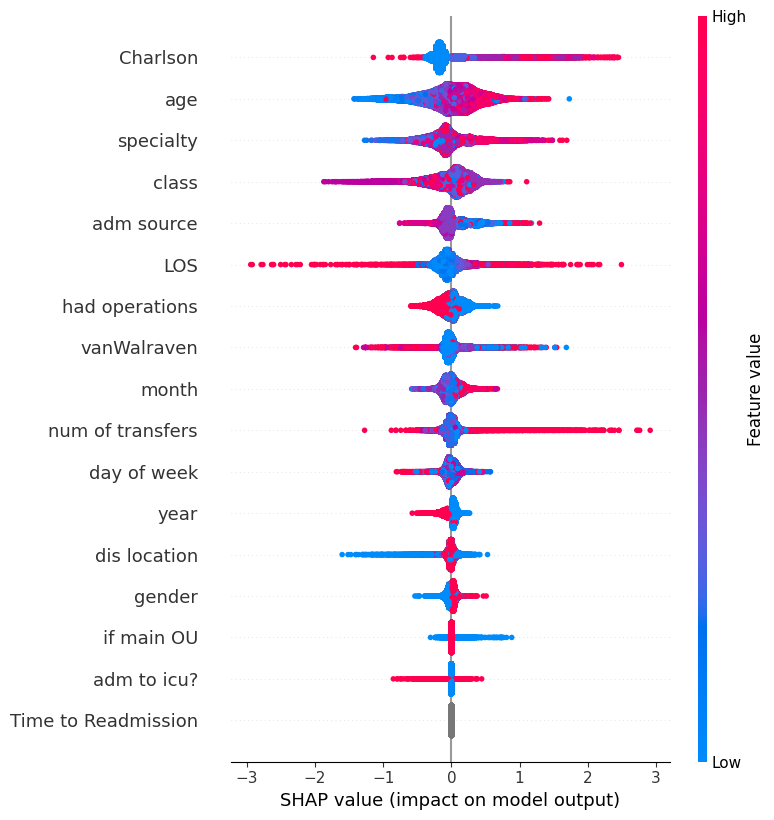

import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
clf.fit(X_train, y_train)

# Create an explainer object
explainer = shap.TreeExplainer(clf)

# Calculate the SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values[0], X_test, plot_type="bar")

# Plot the feature importance as a bar chart
plt.bar(range(len(shap_values[0])), shap_values[0])
plt.xlabel("Feature")
plt.ylabel("SHAP Value")
plt.title("Feature Importance")
plt.sho

In [15]:
voice_chat()

In [13]:
import pyaudio
import wave
import whisper
import json

# Assuming your existing functions and run() function are defined above
# For example, run(model: str, question: str) processes the query.

def local_voice_chat():
    # Audio recording parameters
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000
    RECORD_SECONDS = 5  # Adjust duration as needed
    WAVE_OUTPUT_FILENAME = "temp_audio.wav"
    
    # Set up PyAudio for recording
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE,
                    input=True, frames_per_buffer=CHUNK)
    print(f"Please speak your query... (Recording for {RECORD_SECONDS} seconds)")
    
    frames = []
    for _ in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    
    print("Finished recording.")
    
    stream.stop_stream()
    stream.close()
    p.terminate()
    
    # Save the recorded audio to a WAV file
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    
    model = whisper.load_model("small")
    
    # Transcribe the audio file using Whisper
    result = model.transcribe(WAVE_OUTPUT_FILENAME)
    result_text = result["text"].strip()
    
    if result_text:
        print(f"You said: {result_text}")
        # Process the transcribed query using your chatbot's run function
        run(model="Llama3.2", question=result_text)
    else:
        print("No speech recognized. Please try again.")

Please speak your query... (Recording for 5 seconds)
Finished recording.


c:\Users\baliu\anaconda3\envs\a1\lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


You said: Generate a SHAP summary plot.


c:\Users\baliu\anaconda3\envs\a1\lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


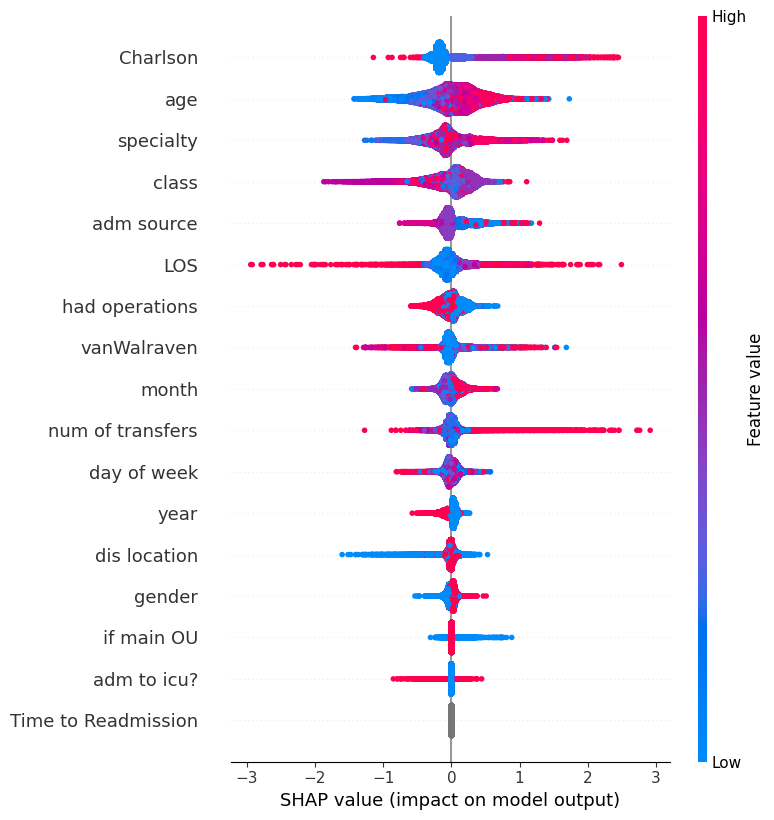

import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from shap import plot_graphic, SHAPValues
from matplotlib import pyplot as plt

# Generate a sample dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model on the training data
model = LogisticRegression()
model.fit(X_train, y_train)

# Generate SHAP values for the trained model
explainer = SHAP(model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importances
plot_graphic(shap_values[0], matplotlib=True)


In [14]:
local_voice_chat()

In [1]:
%pip install pyttsx3

  Using cached pypiwin32-223-py3-none-any.whl.metadata (236 bytes)
Using cached pypiwin32-223-py3-none-any.whl (1.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [16]:
import pyaudio
import wave
import whisper
import pyttsx3
import json

# Assuming your existing functions and run() function are defined above
# For example, run(model: str, question: str) processes the query and returns a response.

def speak_text(text):
    """Converts text to speech and plays it."""
    engine = pyttsx3.init()
    engine.setProperty("rate", 160)  # Adjust speaking speed
    engine.say(text)
    engine.runAndWait()

def local_voice_chat():
    # Audio recording parameters
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000
    RECORD_SECONDS = 5  # Adjust duration as needed
    WAVE_OUTPUT_FILENAME = "temp_audio.wav"
    
    # Set up PyAudio for recording
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE,
                    input=True, frames_per_buffer=CHUNK)
    print(f"Please speak your query... (Recording for {RECORD_SECONDS} seconds)")

    frames = []
    for _ in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    
    print("Finished recording.")
    
    stream.stop_stream()
    stream.close()
    p.terminate()
    
    # Save the recorded audio to a WAV file
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    
    model = whisper.load_model("small")
    
    # Transcribe the audio file using Whisper
    result = model.transcribe(WAVE_OUTPUT_FILENAME)
    result_text = result["text"].strip()
    
    if result_text:
        print(f"You said: {result_text}")
        
        # Process the transcribed query using your chatbot's run function
        response = run(model="Llama3.2", question=result_text)
        
        if response:
            print(f"Llama3.2 says: {response}")
            speak_text(response)  # Convert response to speech
        else:
            print("No valid response generated.")
    else:
        print("No speech recognized. Please try again.")


In [9]:
import pyaudio
import wave
import whisper
import pyttsx3
import os
import json

def generate_response_audio(text, filename="response.wav"):
    """Converts text to speech, saves it as an audio file, and returns the filename."""
    try:
        engine = pyttsx3.init()
        engine.setProperty("rate", 160)  # Adjust speaking speed
        engine.save_to_file(text, filename)
        engine.runAndWait()
        print(f"Audio clip saved as {filename}.")
        return filename
    except Exception as e:
        print(f"Error generating audio: {e}")
        return None

def play_audio_clip(filename):
    """Plays an audio clip from a given WAV file."""
    try:
        # Open the WAV file
        wf = wave.open(filename, 'rb')
        p = pyaudio.PyAudio()

        # Open a stream for audio playback
        stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                        channels=wf.getnchannels(),
                        rate=wf.getframerate(),
                        output=True)

        # Read data in chunks and play
        chunk = 1024
        data = wf.readframes(chunk)
        while data:
            stream.write(data)
            data = wf.readframes(chunk)

        # Cleanup
        stream.stop_stream()
        stream.close()
        p.terminate()
        wf.close()
    except Exception as e:
        print(f"Error playing audio: {e}")

def local_voice_chat():
    # Audio recording parameters
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000
    RECORD_SECONDS = 5  # Adjust duration as needed
    WAVE_OUTPUT_FILENAME = "temp_audio.wav"
    
    try:
        # Set up PyAudio for recording
        p = pyaudio.PyAudio()
        stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE,
                        input=True, frames_per_buffer=CHUNK)
        print(f"Please speak your query... (Recording for {RECORD_SECONDS} seconds)")

        frames = []
        for _ in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
            data = stream.read(CHUNK)
            frames.append(data)
    
        print("Finished recording.")
        
        stream.stop_stream()
        stream.close()
        p.terminate()
    
        # Save the recorded audio to a WAV file
        wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))
        wf.close()
        
        # Load Whisper model and transcribe
        whisper_model = whisper.load_model("small")
        result = whisper_model.transcribe(WAVE_OUTPUT_FILENAME)
        result_text = result["text"].strip()
    
        if result_text:
            print(f"You said: {result_text}")
            
            # Process the transcribed query using your chatbot's run function
            response = run(model="Llama3.2", question=result_text)
            
            if response:
                print(f"Llama3.2 says: {response}")
                # Generate audio clip for the response
                audio_file = generate_response_audio(response, filename="response.wav")
                if audio_file:
                    # Immediately play the audio clip
                    play_audio_clip(audio_file)
            else:
                print("No valid response generated.")
        else:
            print("No speech recognized. Please try again.")
    
    except Exception as e:
        print(f"An error occurred: {e}")
    
    finally:
        # Clean up the temporary recording file
        if os.path.exists(WAVE_OUTPUT_FILENAME):
            os.remove(WAVE_OUTPUT_FILENAME)
            print(f"Temporary file {WAVE_OUTPUT_FILENAME} deleted.")

Please speak your query... (Recording for 5 seconds)
Finished recording.
You said: generate a SHAP summary plot.


c:\Users\baliu\anaconda3\envs\a1\lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


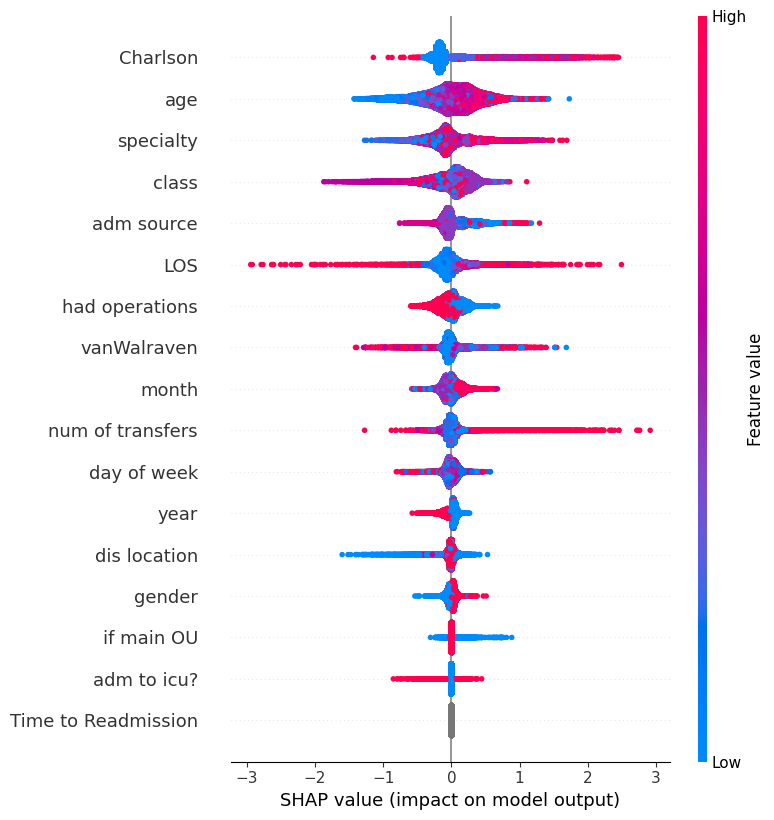

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from shap import SHAP

# Generate some data
np.random.seed(0)
X = pd.DataFrame(np.random.rand(100, 10))
y = np.random.rand(100)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model and fit it to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Calculate the SHAP values for the linear regression model
shap = SHAP(model)
shap_values = shap.explaining_values()

# Plot the feature importance
plt.figure(figsize=(10, 8))
f

KeyboardInterrupt: 

In [11]:
local_voice_chat()

In [10]:
local_voice_chat()

Please speak your query... (Recording for 5 seconds)
Finished recording.
You said: What is the model's accuracy?
The accuracy of a machine learning model can vary depending on the specific task, dataset, and evaluation metrics used. In general, an accuracy of 70.85% is considered to be a good performance for many classification tasks.

To provide more context, here are some common accuracy ranges for different types of machine learning models:

* Simple linear regression: 60-80%
* Decision trees: 70-90%
* Random forests: 75-95%
* Support vector machines (SVMs): 80-98%
* Neural networks: 85-99%

Keep in mind that accuracy is just one metric for evaluating model performance. Other metrics, such as precision, recall, F1 score, and ROC-AUC score, can provide additional insights into the model's strengths and weaknesses.

If you'd like to discuss your specific model or task, I'd be happy to help you explore ways to improve its accuracy!
Llama3.2 says: The accuracy of a machine learning mode

KeyboardInterrupt: 